Quickstart
==========

In this short tutorial we will guide you through a series of steps that
will help you getting started using **SDV**.

Model the dataset using SDV
---------------------------

To model a multi table, relational dataset, we follow two steps. In the
first step, we will load the data and configures the meta data. In the
second step, we will use the SDV API to fit and save a hierarchical
model. We will cover these two steps in this section using an example
dataset.

### Load example data

**SDV** comes with a toy dataset to play with, which can be loaded using
the `sdv.load_demo` function:

In [1]:
from sdv import load_demo

metadata, tables = load_demo(metadata=True)

This will return two objects:

1.  A `Metadata` object with all the information that **SDV** needs to
    know about the dataset.

In [2]:
metadata

Metadata
  root_path: .
  tables: ['users', 'sessions', 'transactions']
  relationships:
    sessions.user_id -> users.user_id
    transactions.session_id -> sessions.session_id

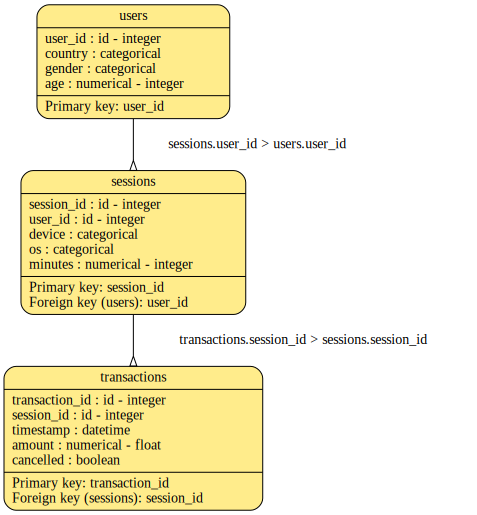

In [3]:
metadata.visualize()

For more details about how to build the `Metadata` for your own dataset,
please refer to the [Relational Metadata](relational_data/01_Relational_Metadata.ipynb)
guide.

2.  A dictionary containing three `pandas.DataFrames` with the tables
    described in the metadata object.

In [4]:
tables

{'users':    user_id country gender  age
 0        0      US      M   34
 1        1      UK      F   23
 2        2      ES   None   44
 3        3      UK      M   22
 4        4      US      F   54
 5        5      DE      M   57
 6        6      BG      F   45
 7        7      ES   None   41
 8        8      FR      F   23
 9        9      UK   None   30,
 'sessions':    session_id  user_id  device       os  minutes
 0           0        0  mobile  android       23
 1           1        1  tablet      ios       12
 2           2        2  tablet  android        8
 3           3        3  mobile  android       13
 4           4        4  mobile      ios        9
 5           5        5  mobile  android       32
 6           6        6  mobile      ios        7
 7           7        7  tablet      ios       21
 8           8        8  mobile      ios       29
 9           9        9  tablet      ios       34,
 'transactions':    transaction_id  session_id           timestamp  amount 

### Fit a model using the SDV API.

First, we build a hierarchical statistical model of the data using
**SDV**. For this we will create an instance of the `sdv.SDV` class and
use its `fit` method.

During this process, **SDV** will traverse across all the tables in your
dataset following the primary key-foreign key relationships and learn
the probability distributions of the values in the columns.

In [5]:
from sdv import SDV

sdv = SDV()
sdv.fit(metadata, tables)

Detecting a new config from the data ... SUCCESS
Setting the new config ... SUCCESS
Config:
{
    "sdtypes": {
        "timestamp": "datetime",
        "amount": "numerical",
        "cancelled": "boolean"
    },
    "transformers": {
        "timestamp": UnixTimestampEncoder(missing_value_replacement='mean'),
        "amount": FloatFormatter(missing_value_replacement='mean'),
        "cancelled": BinaryEncoder(missing_value_replacement='mode')
    }
}
Detecting a new config from the data ... SUCCESS
Setting the new config ... SUCCESS
Config:
{
    "sdtypes": {
        "device": "categorical",
        "os": "categorical",
        "minutes": "numerical",
        "__transactions__session_id__covariance__0__0": "numerical",
        "__transactions__session_id__covariance__1__0": "numerical",
        "__transactions__session_id__covariance__1__1": "numerical",
        "__transactions__session_id__univariates__timestamp.value__loc": "numerical",
        "__transactions__session_id__univaria

Sample data from the fitted model
---------------------------------

Once the modeling has finished you are ready to generate new synthetic
data using the `sdv` instance that you have.

For this, all you have to do is call the `sample_all` method from your
instance passing the number of rows that you want to generate:

In [8]:
sampled = sdv.sample_all()

This will return a dictionary identical to the `tables` one that we
passed to the SDV instance for learning, filled in with new synthetic
data.

<div class="alert alert-info">

**Note**

Only the parent tables of your dataset will have the specified number of
rows, as the number of child rows that each row in the parent table has
is also sampled following the original distribution of your dataset.

</div>

In [9]:
sampled

{'users':    user_id country gender  age
 0       10      FR      F   51
 1       11      FR      M   39
 2       12      ES    NaN   33
 3       13      UK    NaN   39
 4       14      FR      F   45
 5       15      UK      M   36
 6       16      ES      F   28
 7       17      UK    NaN   27
 8       18      UK      F   22
 9       19      US      F   25,
 'sessions':    session_id  user_id  device       os  minutes
 0          10       10  mobile  android        7
 1          11       11  mobile  android       30
 2          12       12  mobile  android       30
 3          13       13  tablet      ios       26
 4          14       14  tablet      ios       10
 5          15       15  tablet  android        7
 6          16       16  mobile  android        7
 7          17       17  tablet  android       16
 8          18       18  tablet      ios       28
 9          19       19  mobile      ios       15,
 'transactions':    transaction_id  session_id                     timestam

Saving and Loading your model
-----------------------------

In some cases, you might want to save the fitted SDV instance to be able
to generate synthetic data from it later or on a different system.

In order to do so, you can save your fitted `SDV` instance for later
usage using the `save` method of your instance.

In [10]:
sdv.save('sdv.pkl')

The generated `pkl` file will not include any of the original data in
it, so it can be safely sent to where the synthetic data will be
generated without any privacy concerns.

Later on, in order to sample data from the fitted model, we will first
need to load it from its `pkl` file.

In [11]:
sdv = SDV.load('sdv.pkl')

After loading the instance, we can sample synthetic data using its
`sample_all` method like before.

In [12]:
sampled = sdv.sample_all(5)
sampled

{'users':    user_id country gender  age
 0       20      UK      F   29
 1       21      UK    NaN   25
 2       22      ES      F   54
 3       23      ES      F   45
 4       24      US      F   22,
 'sessions':    session_id  user_id  device       os  minutes
 0          20       20  mobile      ios       19
 1          21       21  tablet  android       19
 2          22       22  mobile      ios       15
 3          23       23  mobile      ios        8
 4          24       24  mobile      ios       23,
 'transactions':    transaction_id  session_id                     timestamp  amount  cancelled
 0              20          20 2019-01-03 13:32:29.578068224   101.4       True
 1              21          21 2019-01-01 12:34:32.000000000    78.4      False
 2              22          22 2019-01-09 08:09:22.543568384   102.6       True
 3              23          23 2019-01-12 20:22:33.495309824   112.1       True
 4              24          24 2019-01-16 19:59:10.118845696    88.9 